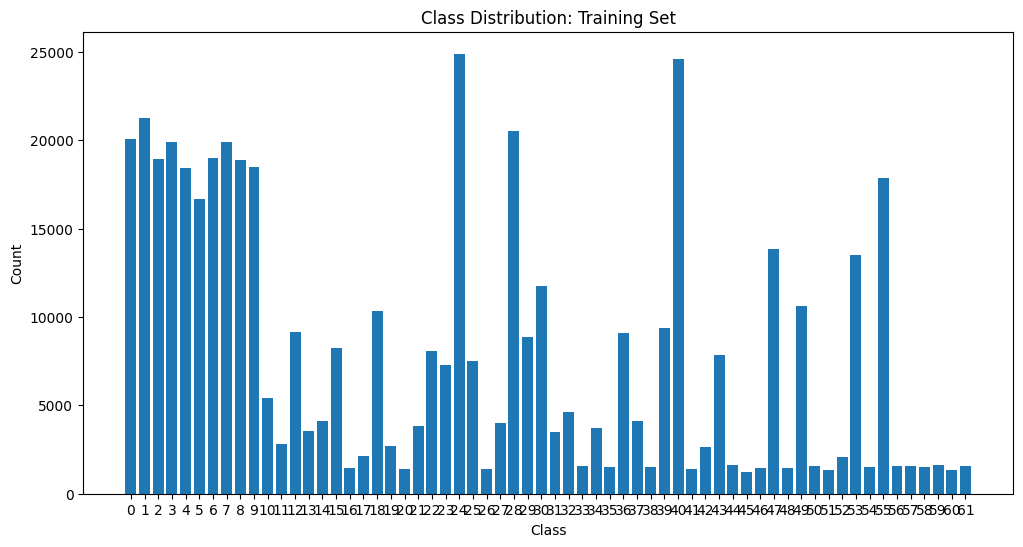

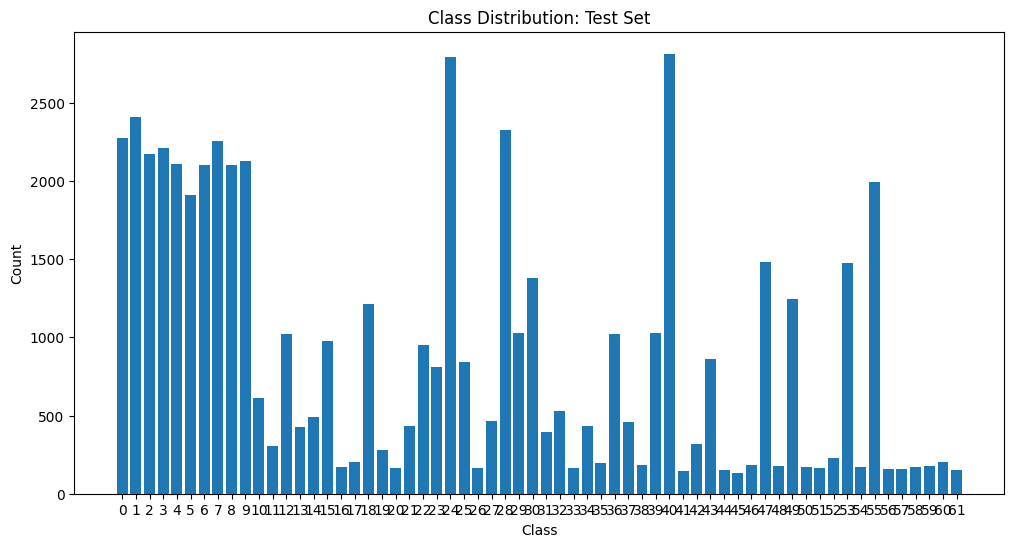

In [6]:
import json
import os
import torch
from torch.utils.data import DataLoader, TensorDataset

# =========================
# 🔹 클라이언트별 Non-IID 특성 보존 병합
# =========================
def merge_with_bias_preservation(data_dir, prefix="train"):
    """
    각 클라이언트의 데이터 분포를 그대로 유지하며 통합
    ▶ 원본 데이터의 계층적 구조 보존
    ▶ 클라이언트 순서에 따른 데이터 배치 유지
    """
    client_data = {}  # {client_id: (x, y)}

    for client_id in range(20):
        file_path = os.path.join(data_dir, f"all_data_{client_id}_niid_0_{prefix}_9.json")
        with open(file_path, 'r') as f:
            data = json.load(f)
            for user_id in data['users']:
                user_x = torch.tensor(data['user_data'][user_id]['x']).float()
                user_y = torch.tensor(data['user_data'][user_id]['y']).long()
                
                # 클라이언트별 데이터 누적
                if client_id not in client_data:
                    client_data[client_id] = (user_x, user_y)
                else:
                    client_data[client_id] = (
                        torch.cat([client_data[client_id][0], user_x]),
                        torch.cat([client_data[client_id][1], user_y])
                    )

    # 클라이언트 순서 유지하며 통합
    x_combined = torch.cat([client_data[i][0] for i in range(20)])
    y_combined = torch.cat([client_data[i][1] for i in range(20)])
    
    # FEMNIST 형태로 리쉐이프 (28x28 이미지)
    return x_combined.reshape(-1, 1, 28, 28), y_combined

# =========================
# 🔹 데이터 분포 시각화 함수 (검증용)
# =========================
def visualize_distribution(labels, title):
    import matplotlib.pyplot as plt
    from collections import Counter
    
    count = Counter(labels.numpy())
    plt.figure(figsize=(12,6))
    plt.bar(count.keys(), count.values())
    plt.title(f"Class Distribution: {title}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(range(62))  # FEMNIST 62개 클래스
    plt.show()

# =========================
# 🔹 메인 실행 블록
# =========================
if __name__ == "__main__":
    # 경로 설정
    train_dir = r"C:\Users\ahsld\Desktop\연합학습 시뮬\train"
    test_dir = r"C:\Users\ahsld\Desktop\연합학습 시뮬\test"
    output_dir = r"C:\Users\ahsld\Desktop\연합학습 시뮬\centralized_data"
    os.makedirs(output_dir, exist_ok=True)

    # Train 데이터 병합
    x_train, y_train = merge_with_bias_preservation(train_dir, "train")
    visualize_distribution(y_train, "Training Set")
    
    # Test 데이터 병합
    x_test, y_test = merge_with_bias_preservation(test_dir, "test")
    visualize_distribution(y_test, "Test Set")

    # 데이터 저장
    torch.save((x_train, y_train), os.path.join(output_dir, "biased_train.pt"))
    torch.save((x_test, y_test), os.path.join(output_dir, "biased_test.pt"))
    
    # 데이터 로더 생성 (Shuffle=False 권장)
    train_loader = DataLoader(TensorDataset(x_train, y_train), 
                            batch_size=64, 
                            shuffle=False)  # ✅ Non-IID 특성 보존
    
    test_loader = DataLoader(TensorDataset(x_test, y_test),
                           batch_size=64,
                           shuffle=False)


In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# ====================================
# 🔹 데이터 병합 함수 (Non-IID 유지)
# ====================================
def merge_with_bias_preservation(data_dir, prefix="train"):
    client_data = {}
    for client_id in range(20):
        file_path = os.path.join(data_dir, f"all_data_{client_id}_niid_0_{prefix}_9.json")
        with open(file_path, 'r') as f:
            data = json.load(f)
            for user_id in data['users']:
                user_x = torch.tensor(data['user_data'][user_id]['x']).float()
                user_y = torch.tensor(data['user_data'][user_id]['y']).long()
                if client_id not in client_data:
                    client_data[client_id] = (user_x, user_y)
                else:
                    client_data[client_id] = (
                        torch.cat([client_data[client_id][0], user_x]),
                        torch.cat([client_data[client_id][1], user_y])
                    )
    x_combined = torch.cat([client_data[i][0] for i in range(20)])
    y_combined = torch.cat([client_data[i][1] for i in range(20)])
    return x_combined.reshape(-1, 1, 28, 28), y_combined

# ====================================
# 🔹 Dropout 포함 CNN 모델 정의
# ====================================
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 62)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.head(x)
        return x

# ====================================
# 🔹 학습 및 평가 함수 정의
# ====================================
def train_and_evaluate():
    base_dir = r"C:\Users\ahsld\Desktop\연합학습 시뮬"
    save_dir = os.path.join(base_dir, "중results")
    os.makedirs(save_dir, exist_ok=True)

    train_path = os.path.join(base_dir, "centralized_data", "biased_train.pt")
    test_path = os.path.join(base_dir, "centralized_data", "biased_test.pt")

    x_train, y_train = torch.load(train_path)
    x_test, y_test = torch.load(test_path)

    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=32, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DeepCNN().to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

    num_epochs = 100
    best_acc = 0.0

    train_loss_list = []
    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total
        train_loss_list.append(total_loss)
        train_acc_list.append(train_acc)
        print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f}, Accuracy: {train_acc:.2f}%")

        model.eval()
        correct_val, total_val = 0.0, 0.0
        with torch.no_grad():
            for images_val, labels_val in test_loader:
                outputs_val = model(images_val.to(device))
                correct_val += (outputs_val.argmax(1) == labels_val.to(device)).sum().item()
                total_val += labels_val.size(0)

        val_acc = correct_val / total_val * 100
        val_acc_list.append(val_acc)
        print(f"[Epoch {epoch+1}] Validation Accuracy: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))

        # 🔸 에포크별 결과 저장 (.json 파일로)
        epoch_result = {
            "accuracy": float(val_acc),
            "loss": float(total_loss)
        }
        with open(os.path.join(save_dir, f"round_{epoch+1}_metrics.json"), "w") as f:
            json.dump(epoch_result, f)

    # 🔸 전체 메트릭 저장 (.pt)
    metrics = {
        "train_loss": train_loss_list,
        "train_acc": train_acc_list,
        "val_acc": val_acc_list
    }
    torch.save(metrics, os.path.join(save_dir, "epoch_metrics.pt"))

# 🔹 실행
train_and_evaluate()


C:\Users\ahsld\AppData\Local\Temp\ipykernel_51476\875975798.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_train, y_train = torch.load(train_path)
C:\Users\ahsld\App

[Epoch 1] Loss: 23398.9085, Accuracy: 57.59%
[Epoch 1] Validation Accuracy: 75.02%


KeyboardInterrupt: 